**Chapter 8 - Time Series Examples Using Generated Data**

Oftentimes, generated data is needed to help really explain concepts in Time Series. This means that YOU create your own data based on specific parameters: in this case, you are creating your own AR(p) and MA(q) data. You can also create your own examples to get a sense of how to interpret ACF/PACF and predict for different types of models. 

In [15]:
# The following code creates a function that we can use to check stationarity very easily.

from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import arma_generate_sample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa as sm

**Choose coefficients and number of data points**

Create coefficients to set up the data. You can tell Python how many samples you want to create (or datapoints), along with setting your own coefficients for a AR(p) and MA(q) model, or both. See word document for details.

**EXAMPLE:** Change some of the numbers below and see how they change your ACF/PACF plots when you run the code, along with significance levels and coefficients for your models. Try deleting a number to create an AR(1) or MA(1) model. 

In [17]:
num_samples =  128    # number of data points to create

# AR(2) coefficients
arparams = np.array([.5, -.5])    # xt = c + 0.5xt-1 - 0.5xt-2 + wt

# MA(2) coefficients
maparams = np.array([.5, .5])    # xt = mu + wt + 0.5wt-1 + 0.5wt-2

**AR(2) Model**

The following generates a dataset that follows an AR(2) process with coefficients 0.5 and -0.5, as seen above. Be careful, for an AR model, the arparams should be negative to avoid some potential problems. 

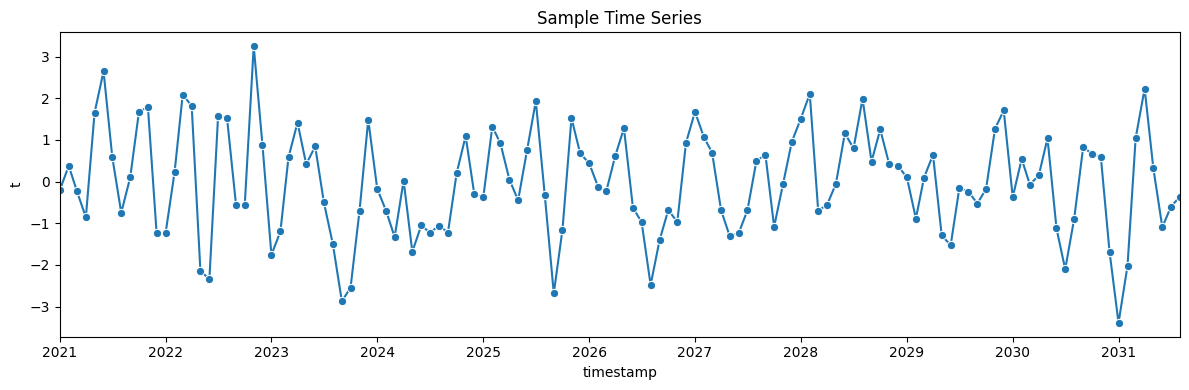

In [18]:
np.random.seed(12345)   # Choose any number (doesn't have to be 12345). This is just a pre-saved starter to generate data.
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1] # add zero-lag

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=num_samples, freq='MS'),
                       't' : sm.arima_process.arma_generate_sample(ar, ma, num_samples)   # removed .tsa
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

**Stationarity**

Use the new function to check for stationarity.

In [19]:
check_stationarity(sample['t'])

ADF Statistic: -10.441598
p-value: 0.000000
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Stationary


**ACF/PACF plots**

For an AR(2) process, there should be two **significant** lags in the PACF, so much so it looks like it cuts off from the following lags. The ACF should be more of a tailing off. Try changing these plots with different types of models. You will notice some are easier to spot than others.  

*NOTE*: You can change the figure size as well. Try it out.

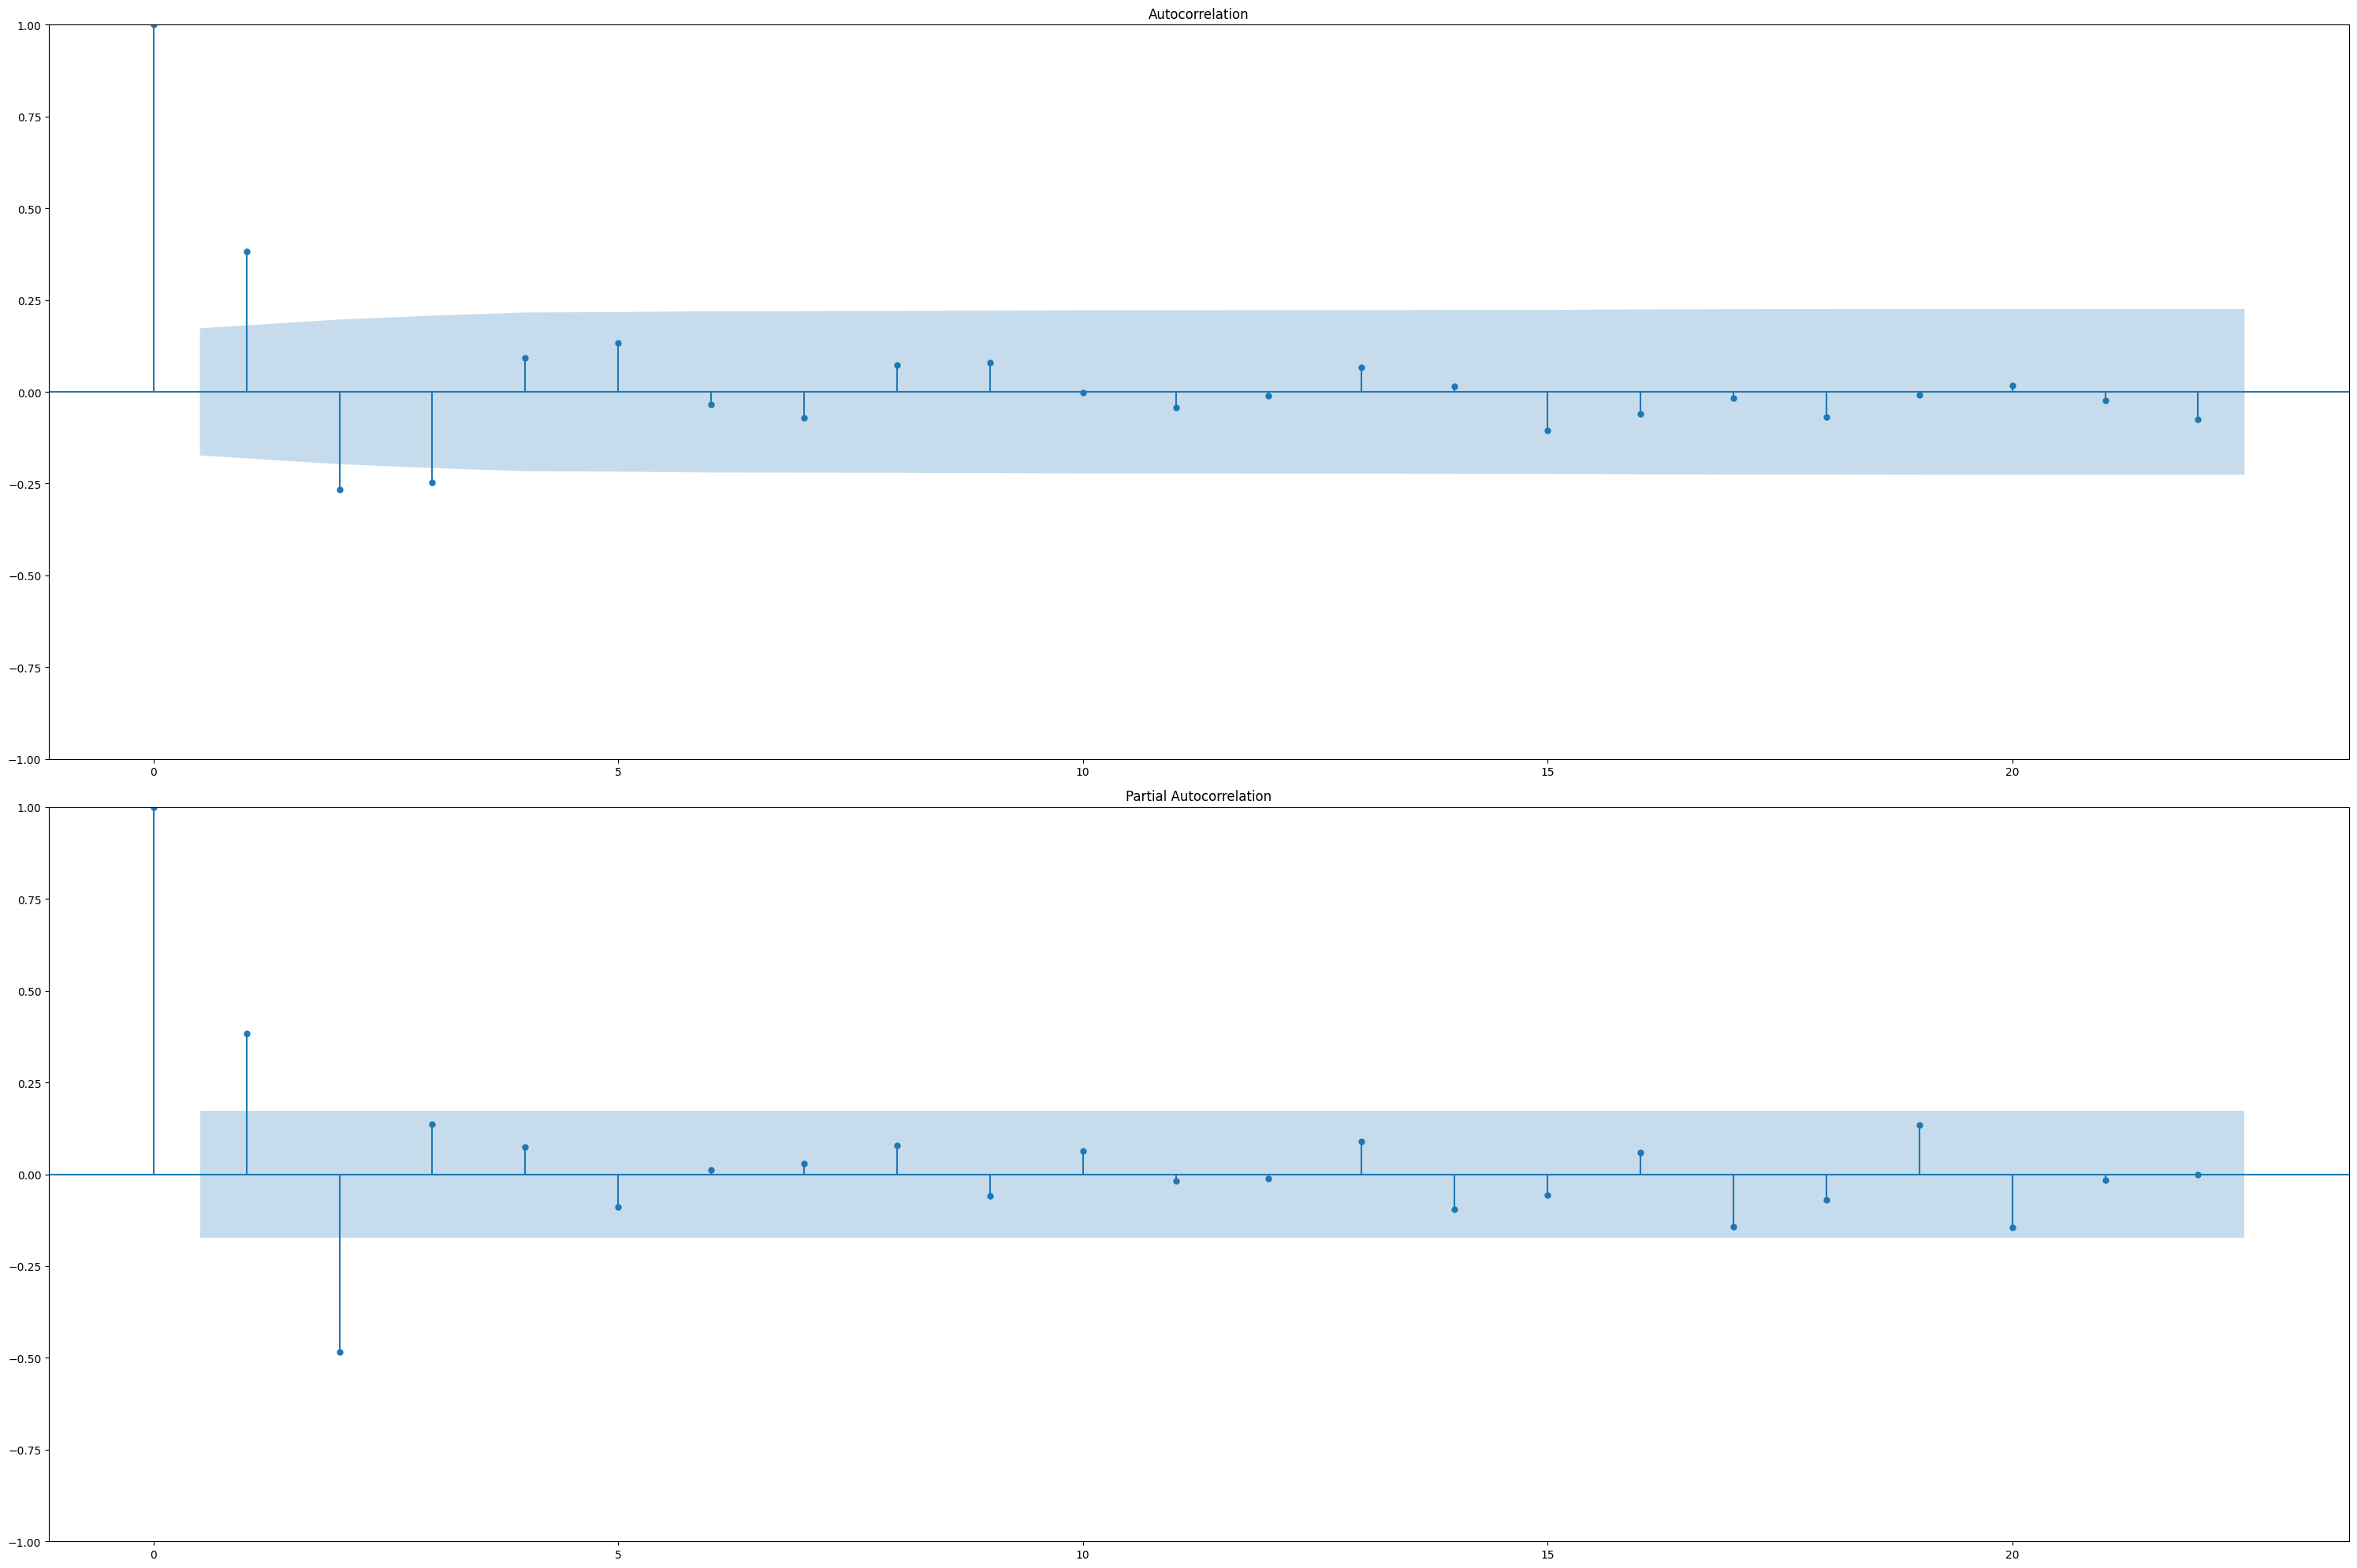

In [20]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(30, 20))
plot_acf(sample['t'], ax=ax[0])
plot_pacf(sample['t'], ax=ax[1])

plt.tight_layout()
plt.show()

**Building a Model**

The ACF/PACF plot is supposed to guide us to build a model. *Refer to the word document for how to do this*. The simple line of code below does the following:

* Takes the column of data being predicted
* Takes the number of coefficients for AR, MA, and the number of times the data is differenced

In the following example, ARIMA calculates the coefficients and their significance for sample.t column of data, with AR(2), no differencing, and 0 for MA coefficients. Specifically, **order=(p,d,q)**, where AR(p), d=differencing, and MA(q).

*EXAMPLE*: change the numbers for order=(2, 0, 0) and notice how coefficients and significance levels change. Just like multiple linear regression, we use *stepwise* variable selection, where we delete variables based on significance level (p-values), to get a final model.

In [21]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(sample.t, order=(2, 0, 0))    # order=(p,d,q) where AR(p), d means number of times differenced, and MA(q)
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      t   No. Observations:                  128
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -183.240
Date:                Fri, 14 Feb 2025   AIC                            374.480
Time:                        15:01:26   BIC                            385.889
Sample:                             0   HQIC                           379.116
                                - 128                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0297      0.098     -0.303      0.762      -0.222       0.162
ar.L1          0.5646      0.083      6.831      0.000       0.403       0.727
ar.L2         -0.4774      0.085     -5.610      0.0

**FINAL AR(2) Model**: xt = -0.0297 + 0.5646xt-1 - 0.4774xt-2 + wt

This is close to our original xt = c + 0.5xt-1 - 0.5xt-2 + wt model

**MA(2)**

The following code follows the same process, but for MA instead of AR. Notice the difference below.

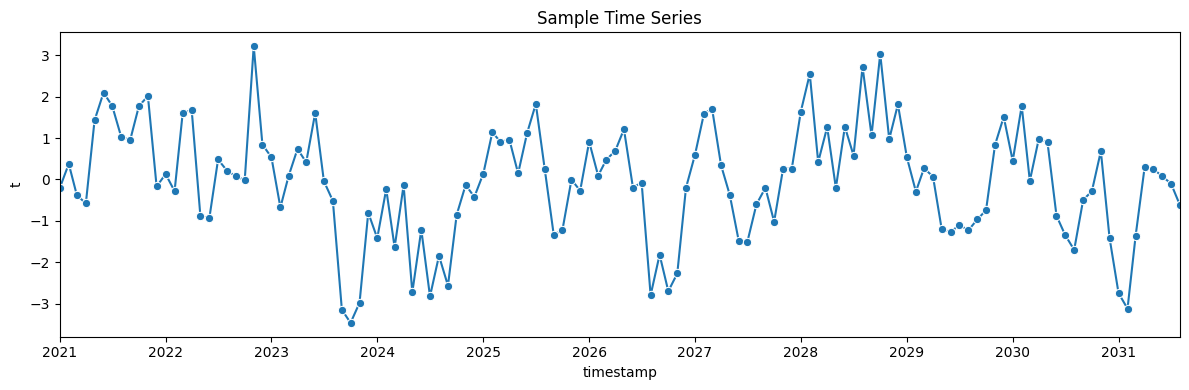

In [22]:
np.random.seed(12345)
ar = np.r_[1] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=num_samples, freq='MS'),
                       't' : sm.arima_process.arma_generate_sample(ar, ma, num_samples)
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

**Moving Average** is different from autoregression, as you can tell. Look at their models: moving average is based on white noise and error, making it a little more volatile. You can see this in the ACF/PACF below.

For MA(2), the ACF plot should have **two significant lags** and clearly cut off afterwards, while the PACF plot tends to tail off. This is not quite cut and dry, but look closely. The ACF has two lags that are much more significant than the others, to the point where it's a clear cut off. However, the PACF plot is significant at lags 1 and 3, but not at 2 and slowly tails off through the rest of the plot (although not as clean as our last example).

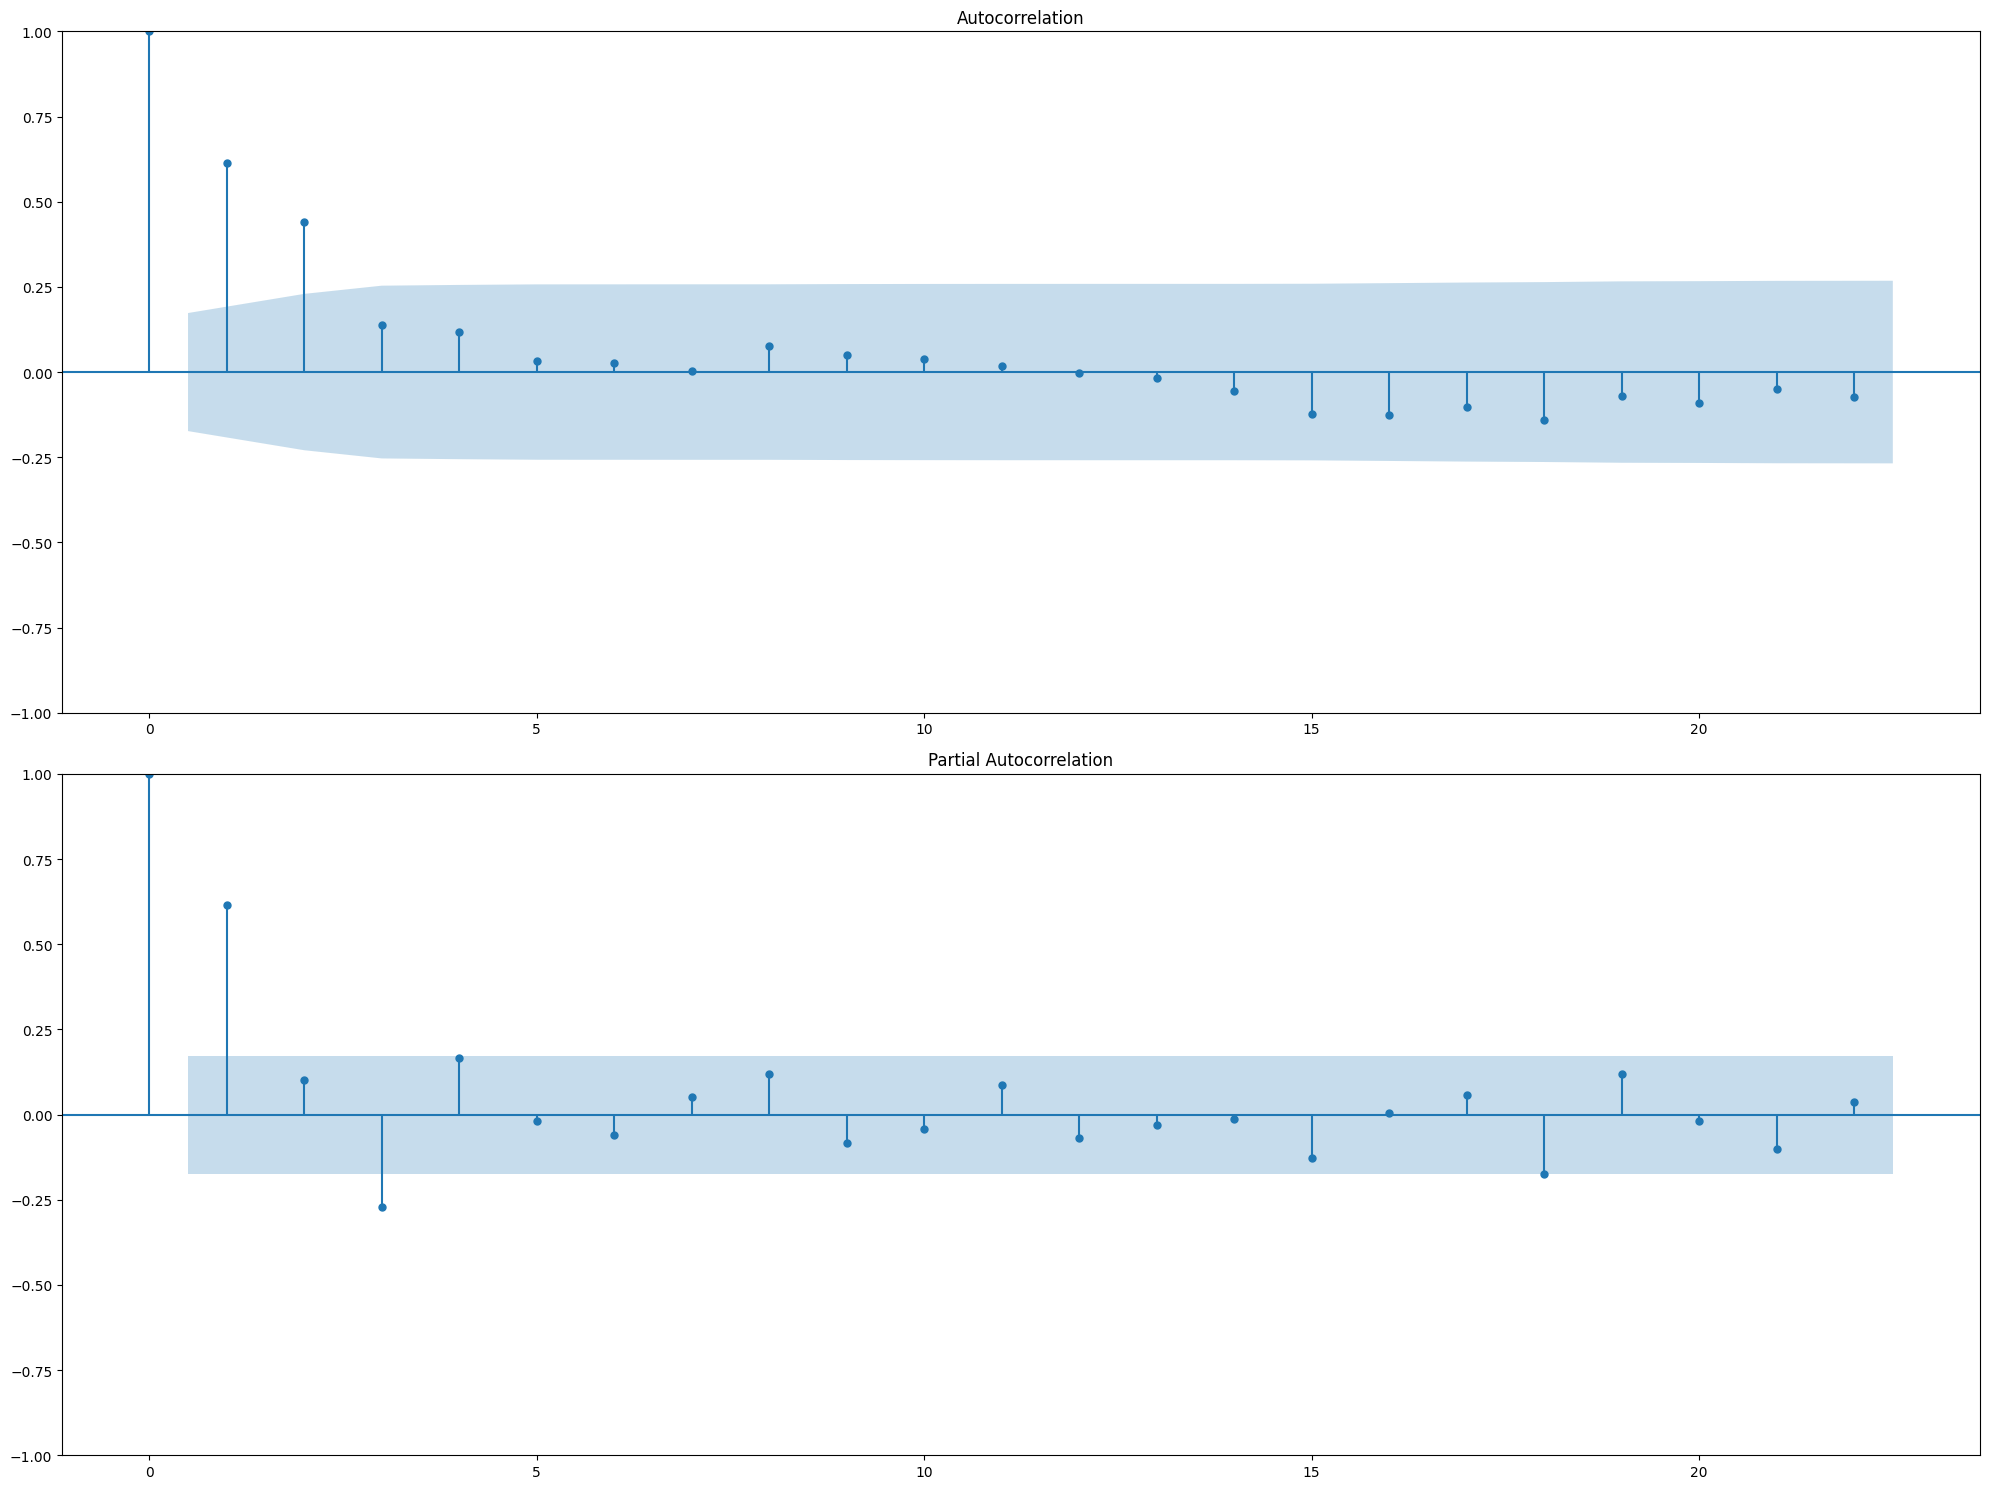

In [23]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))
plot_acf(sample['t'], ax=ax[0])
plot_pacf(sample['t'], ax=ax[1])

plt.tight_layout()
plt.show()

**Modeling**: Try starting with order=(2, 0, 2) just to make sure. You will see that after stepwise variable selection, the final model involves two MA terms with coefficients similar to 0.5, as we generated above. 

In [24]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(sample.t, order=(0, 0, 2)) # We will learn more about order= in the next algorithms
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      t   No. Observations:                  128
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -182.236
Date:                Fri, 14 Feb 2025   AIC                            372.472
Time:                        15:01:26   BIC                            383.880
Sample:                             0   HQIC                           377.107
                                - 128                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0606      0.202     -0.300      0.764      -0.456       0.335
ma.L1          0.6324      0.073      8.665      0.000       0.489       0.775
ma.L2          0.5970      0.079      7.579      0.0

**FINAL MA(2) Model**: xt = -0.0606 + 0.6324wt-1 + 0.5970wt-2 + wt

This is similar to our original coefficients: xt = mu + 0.5wt-1 + 0.5wt-2 + wt

**ARMA(2,2)**

Try the following code, but with BOTH AR and MA coefficients, giving an ARMA(2,2) model.

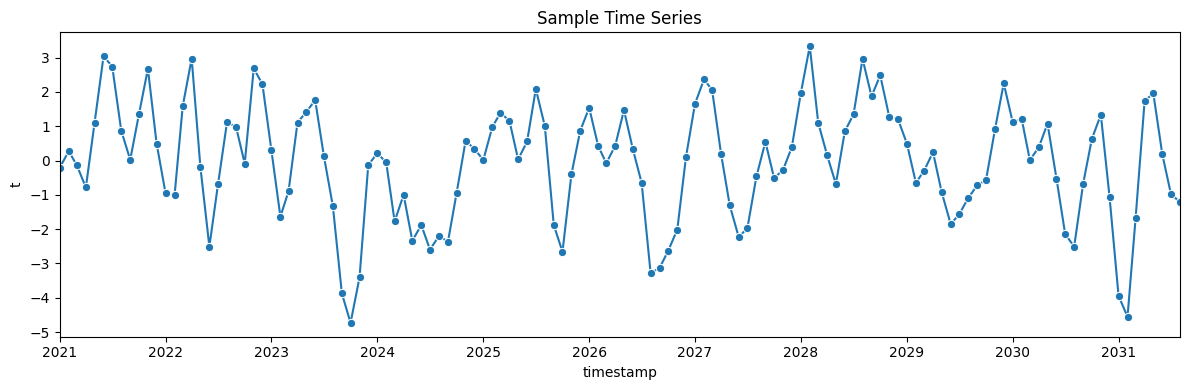

In [25]:
np.random.seed(12345)
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

sample = pd.DataFrame({'timestamp' : pd.date_range('2021-01-01', periods=num_samples, freq='MS'),
                       't' : sm.arima_process.arma_generate_sample(ar, ma, num_samples)
                      })

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=sample.timestamp, y=sample['t'], marker='o')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

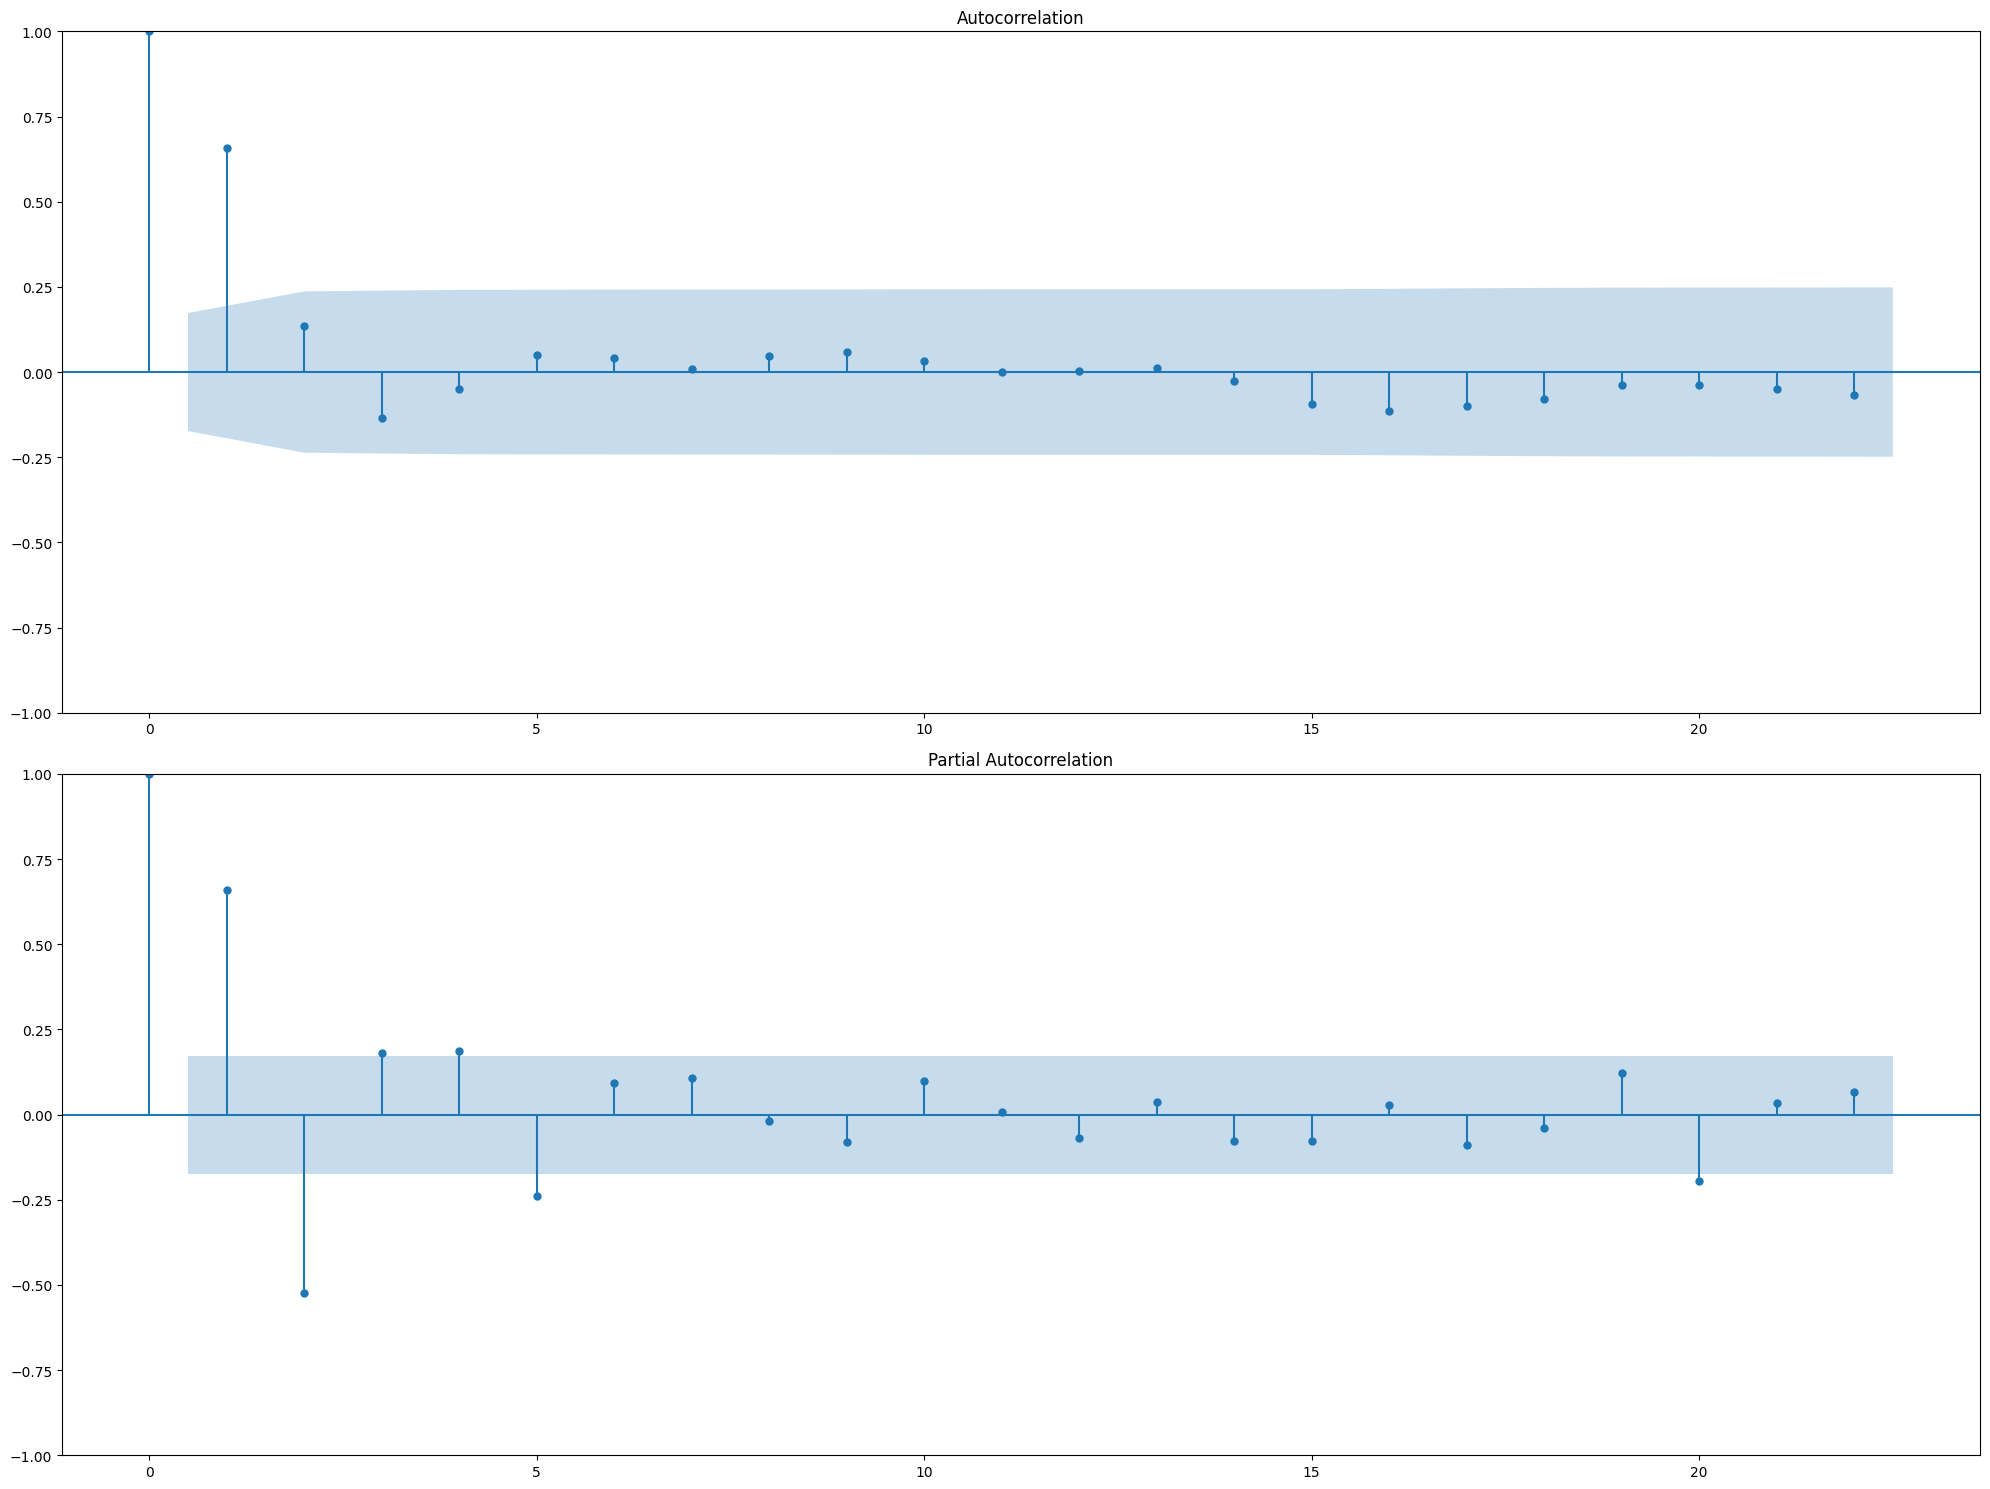

In [26]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))
plot_acf(sample['t'], ax=ax[0])
plot_pacf(sample['t'], ax=ax[1])

plt.tight_layout()
plt.show()

In [27]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(sample.t, order=(2, 0, 0)) # We will learn more about order= in the next algorithms
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      t   No. Observations:                  128
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -191.252
Date:                Fri, 14 Feb 2025   AIC                            390.504
Time:                        15:01:27   BIC                            401.912
Sample:                             0   HQIC                           395.139
                                - 128                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0596      0.185     -0.323      0.747      -0.422       0.302
ar.L1          1.0010      0.078     12.881      0.000       0.849       1.153
ar.L2         -0.5204      0.082     -6.330      0.0

**FINAL ARMA(2,2) Model**: xt = -0.0670 + 0.3717xt-1 - 0.3718xt-2 + 0.7328wt-1 + 0.6569wt-2 + wt

Again, make sure to *reference the word document and tables* for explanation.

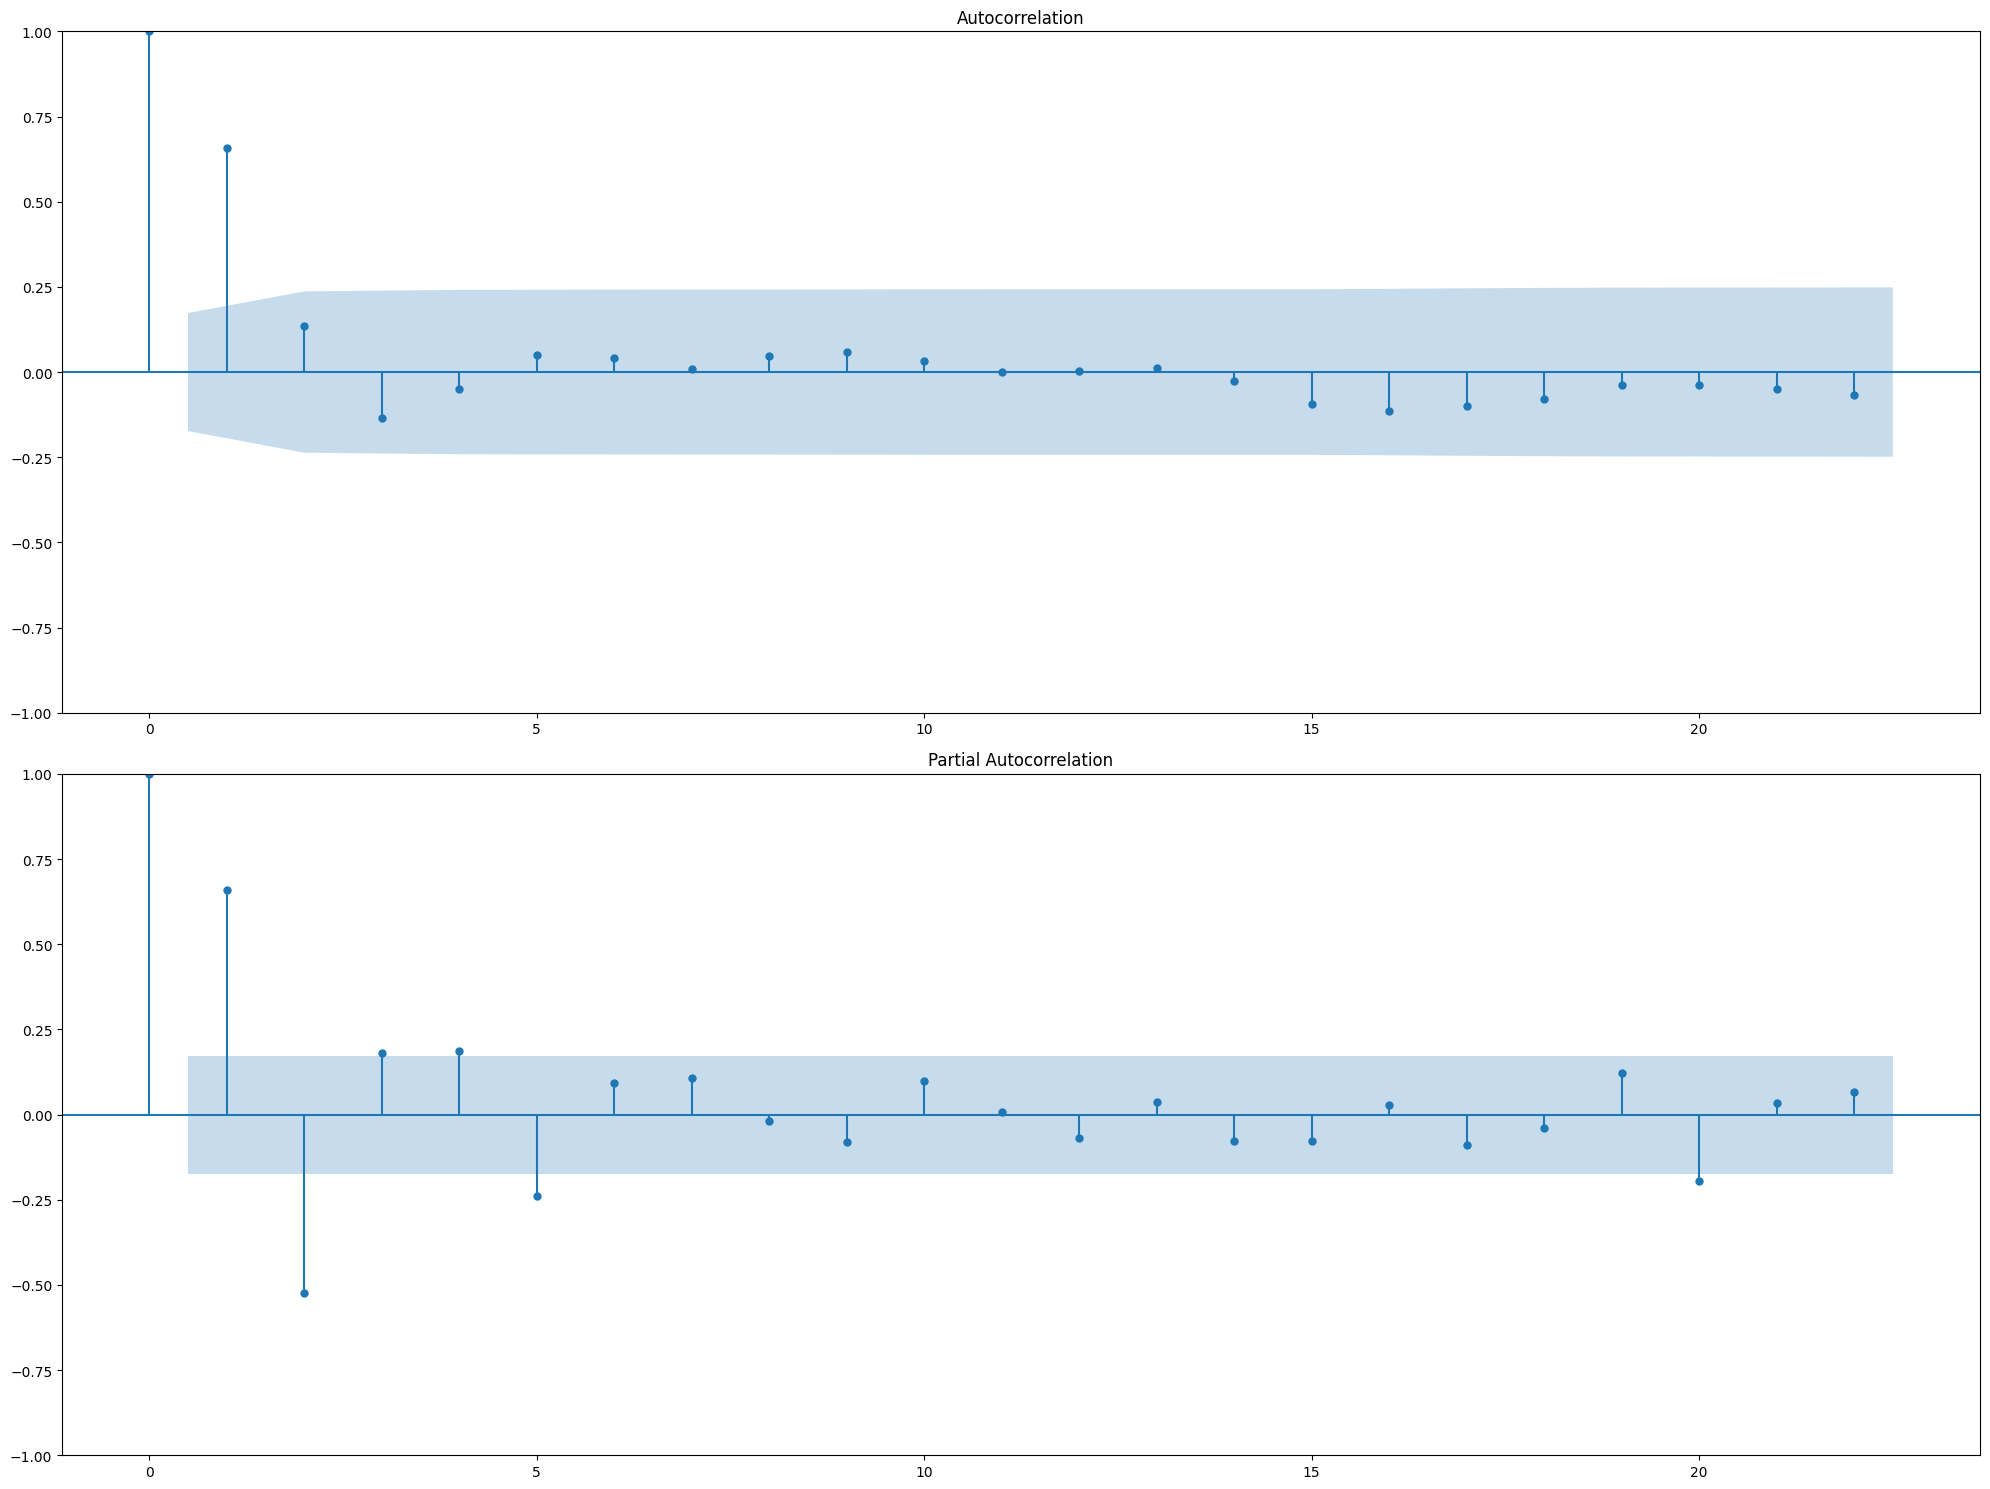

In [28]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))
plot_acf(sample['t'], ax=ax[0])
plot_pacf(sample['t'], ax=ax[1])

plt.tight_layout()
plt.show()